In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split    
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, log_loss)
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [10]:
path = 'C:/Users/cmari/Desktop/Quinto/Capgemini/AnemiaProject/data/raw/star_classification.csv'
data = pd.read_csv(path)

data.dropna(subset=['class'], inplace=True)

data = data[data['u']!=-9999]

X_data = data.drop('class', axis=1)
Y_data = data['class']

In [13]:
param_grid_params = {
    'criterion': ['log_loss', 'gini', 'entropy'],
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf = RandomForestClassifier()
default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)

grids = {
    'Random Forest': RandomizedSearchCV(rf, param_grid_params, scoring='neg_log_loss', **default_grid_params),
}

results = []

X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

for model_name, model in grids.items():
    print('Running', model_name)
    # Note that by default the argument `refit` of `GridSearchCV` is set to True, so that the best estimator 
    # is refit on the whole training set.
    model.fit(X_train, y_train)


    y_pred_proba = model.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_pred_proba, labels=model.classes_)
    print('Log loss:', test_log_loss)

    results.append([test_log_loss])
  

Running Random Forest
Log loss: 0.08573937961190842


c:\Users\cmari\Anaconda3\envs\tensorflow\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


ValueError: could not convert string to float: 'QSO'

In [14]:
pred_prob_test = pd.DataFrame(model.predict_proba(X_test))
    #pred_prob_test.rename(columns = {0: 'Galaxy', 1: 'QSO', 2: 'Star'}, inplace = True)
idx = pred_prob_test.index
pred_prob_test.insert(0, 'id', idx)
pred_prob_test.head()
    
print(f'Best hyperparameters: {model.best_params_}')

Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None, 'criterion': 'entropy'}


In [17]:
model = RandomForestClassifier(n_estimators=300, min_samples_split=2, min_samples_leaf= 2, max_depth=None, criterion='entropy')
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=2,
                       n_estimators=300)

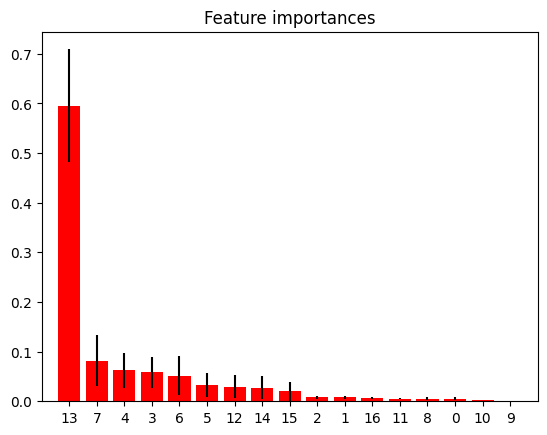

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,0.116123,6121,56187,842


In [24]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X_data.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_data.shape[1]), indices)
plt.xlim([-1, X_data.shape[1]])
plt.show()
X_data.head()

In [25]:
predictions = model.predict(X_test)

# Evaluando el modelo
print("Matriz de confusión:")
print(confusion_matrix(y_test, predictions))
print("\nReporte de clasificación:")
print(classification_report(y_test, predictions))

Matriz de confusión:
[[11734   123    47]
 [  277  3533     0]
 [    3     0  4283]]

Reporte de clasificación:
              precision    recall  f1-score   support

      GALAXY       0.98      0.99      0.98     11904
         QSO       0.97      0.93      0.95      3810
        STAR       0.99      1.00      0.99      4286

    accuracy                           0.98     20000
   macro avg       0.98      0.97      0.97     20000
weighted avg       0.98      0.98      0.98     20000



Obrenemos sobre el conjunto de test unos resultados expecionales, gracias a la clase RandomizedSearchCV en la que hemos buscado los mejores hiperparámetros